# Email spam detection (  Lazy Text Predict ) 

Text classification autoML.

Lazy text predict a actuellement cinq modèles NLP codés en dur :

Trois sont basés sur des réseaux neuronaux:

- Bert

- Albert

- Roberta 

Deux sont basés sur des vecteurs de comptage :

- Bayésien naïf multinomial 

- Support Vector Machine 

In [1]:
import lazypredict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file
from lazytextpredict import basic_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/Users/isslamkhatir/anaconda3/envs/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data= pd.read_csv('/Users/isslamkhatir/Downloads/spam_ham_dataset.csv')
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [3]:
#supprimer les colonnes Unnamed et label_num
data = data.drop('Unnamed: 0', axis=1)
data = data.drop(['label_num'], axis=1)

In [4]:
data

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...
...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...
5169,ham,Subject: industrial worksheets for august 2000...


In [5]:
#compter les hams et les spams dans la dataset
data['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [6]:
data.describe()

,label,text
count,5171,5171
unique,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   object
 1   text    5171 non-null   object
dtypes: object(2)
memory usage: 80.9+ KB


In [8]:
# somme des lignes dupliquées 
data.duplicated().sum()

178

In [9]:
# suppression des lignes dupliquées 
data=data.drop_duplicates(keep='first')

In [10]:
data.shape

(4993, 2)

On a 4993 lignes et 2 colonnes 

In [11]:
# remplacement de 'ham' par 'non-spam' 
data['label'] = data['label'].replace(['ham'],'non-spam')
data['label']

/var/folders/m1/5ps2227d199g23dsl003lzkh0000gn/T/ipykernel_8814/3113428461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace(['ham'],'non-spam')


0       non-spam
1       non-spam
2       non-spam
3           spam
4       non-spam
          ...   
5165    non-spam
5166    non-spam
5167    non-spam
5169    non-spam
5170        spam
Name: label, Length: 4993, dtype: object

In [12]:
# compter le nombre de spam et non-spam
data['label'].value_counts()

label
non-spam    3531
spam        1462
Name: count, dtype: int64

# Text Cleaning

In [13]:
import string

punct = []
for char in string.punctuation:
    punct.append(char)

In [14]:
import re
def cleaning(text):

    # remove multiple space, tabs, newlines
    text = re.sub('\s+',' ',str(text))
    
    # remove links
    text = text.replace("http://", " ").replace("https://", " ")
    
    # remove special characters
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    
    # remove punctuation
    text = ''.join([word for word in text if word not in punct])
    
    #remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "",str(text))
    
    #remove numbers
    text = re.sub(r"\d+", "",str(text))
        
    #remove multiple spaces (again)
    text = re.sub('\s+',' ',str(text))
    
    return str(text)

In [15]:
data['text_cleaned'] = data['text'].apply(lambda x: cleaning(x))
data = data[['text', 'text_cleaned', 'label']]
data

/var/folders/m1/5ps2227d199g23dsl003lzkh0000gn/T/ipykernel_8814/2871223393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_cleaned'] = data['text'].apply(lambda x: cleaning(x))


,text,text_cleaned,label
0,Subject: enron methanol ; meter # : 988291\r\n...,Subject enron methanol meter this is follow up...,non-spam
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",Subject hpl nom for january see attached file ...,non-spam
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",Subject neon retreat ho ho ho we re around to ...,non-spam
3,"Subject: photoshop , windows , office . cheap ...",Subject photoshop windows office cheap main tr...,spam
4,Subject: re : indian springs\r\nthis deal is t...,Subject re indian springs this deal is to book...,non-spam
...,...,...,...
5165,"Subject: fw : crosstex energy , driscoll ranch...",Subject fw crosstex energy driscoll ranch mete...,non-spam
5166,Subject: put the 10 on the ft\r\nthe transport...,Subject put the on the ft the transport volume...,non-spam
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,Subject and following noms hpl can take the ex...,non-spam
5169,Subject: industrial worksheets for august 2000...,Subject industrial worksheets for august activ...,non-spam


On a nettoyé la colonne text par supprimer espace multiple, onglets, nouvelles lignes, caractères spéciaux, ponctuation, caractère unique, nombres.

In [16]:
#la nouvelle data avec 2 colonnes  : text et label 
data = data.drop(['text'], axis=1)
data = data.rename(columns = {'text_cleaned' : 'text'})
data.columns

Index(['text', 'label'], dtype='object')

In [17]:
X = data['text']
y = data['label']

# Lazy Text Predict

In [18]:
trial=basic_classification.LTP(Xdata=X,Ydata=y, csv=None, xlsx=None, x_col='X', y_col='y', models='all') 
# You can choose between 'transformers'-based, 'count-vectorizer'-based, and 'all' models.
# Xdata is a list of text, and Ydata is a list of corresponding labels.
# x_col and y_col are strings that specify the columns of the text and label columns.

converting pandas series to list
converting pandas series to list
X_train length: 4493
X_test length: 500
Y_train length: 4493
Y_test length: 500


In [31]:
trial.run(training_epochs=1)
#This trains the models specified above on the data you loaded. 
#Here you can specify the number of training epochs. 

Training on a dataset with 2 labels


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss


{'eval_loss': 0.10363858938217163, 'eval_accuracy': 0.978, 'eval_f1': 0.9777882519922527, 'eval_precision': 0.9783644809072812, 'eval_recall': 0.978, 'eval_full_report': {'0': {'precision': 0.9724517906336089, 'recall': 0.9971751412429378, 'f1-score': 0.9846582984658299, 'support': 354}, '1': {'precision': 0.9927007299270073, 'recall': 0.9315068493150684, 'f1-score': 0.96113074204947, 'support': 146}, 'accuracy': 0.978, 'macro avg': {'precision': 0.9825762602803081, 'recall': 0.9643409952790032, 'f1-score': 0.97289452025765, 'support': 500}, 'weighted avg': {'precision': 0.9783644809072812, 'recall': 0.978, 'f1-score': 0.9777882519922527, 'support': 500}}, 'eval_runtime': 139.9348, 'eval_samples_per_second': 3.573, 'eval_steps_per_second': 0.057, 'epoch': 1.0}
Training on a dataset with 2 labels


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Step,Training Loss


{'eval_loss': 0.045593563467264175, 'eval_accuracy': 0.988, 'eval_f1': 0.988, 'eval_precision': 0.988, 'eval_recall': 0.988, 'eval_full_report': {'0': {'precision': 0.9915254237288136, 'recall': 0.9915254237288136, 'f1-score': 0.9915254237288136, 'support': 354}, '1': {'precision': 0.9794520547945206, 'recall': 0.9794520547945206, 'f1-score': 0.9794520547945206, 'support': 146}, 'accuracy': 0.988, 'macro avg': {'precision': 0.9854887392616671, 'recall': 0.9854887392616671, 'f1-score': 0.9854887392616671, 'support': 500}, 'weighted avg': {'precision': 0.988, 'recall': 0.988, 'f1-score': 0.988, 'support': 500}}, 'eval_runtime': 142.199, 'eval_samples_per_second': 3.516, 'eval_steps_per_second': 0.056, 'epoch': 1.0}
Training on a dataset with 2 labels


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Step,Training Loss


{'eval_loss': 0.09367190301418304, 'eval_accuracy': 0.976, 'eval_f1': 0.9761390466356908, 'eval_precision': 0.9766070780399274, 'eval_recall': 0.976, 'eval_full_report': {'0': {'precision': 0.9913793103448276, 'recall': 0.9745762711864406, 'f1-score': 0.982905982905983, 'support': 354}, '1': {'precision': 0.9407894736842105, 'recall': 0.9794520547945206, 'f1-score': 0.959731543624161, 'support': 146}, 'accuracy': 0.976, 'macro avg': {'precision': 0.966084392014519, 'recall': 0.9770141629904806, 'f1-score': 0.9713187632650719, 'support': 500}, 'weighted avg': {'precision': 0.9766070780399274, 'recall': 0.976, 'f1-score': 0.9761390466356908, 'support': 500}}, 'eval_runtime': 141.3463, 'eval_samples_per_second': 3.537, 'eval_steps_per_second': 0.057, 'epoch': 1.0}
Training on a dataset with 2 labels
ERROR
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:

# Split the data

In [19]:
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Data preprocessing with CountVectorizer()

Convert a collection of text documents to a matrix of token counts.

In [22]:
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
print(X_train_counts.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [21]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Models

In [23]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [24]:
X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [25]:
text_clf = Pipeline([('count_vec', CountVectorizer()), 
                     ('tfidf_transformer', TfidfTransformer()),
                     ('clf', SGDClassifier(tol=None, n_jobs=-1))]).fit(X_train, y_train)

In [26]:
y_pred = text_clf.predict(X_test)

# Evaluation

In [27]:
target_names = ['non-spam', 'spam']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    non-spam       0.99      0.98      0.99       377
        spam       0.94      0.98      0.96       123

    accuracy                           0.98       500
   macro avg       0.97      0.98      0.97       500
weighted avg       0.98      0.98      0.98       500



In [28]:
print(metrics.accuracy_score(y_test, y_pred))

0.98


In [29]:
print(accuracy_score(y_test, y_pred, normalize=False))

490


In [30]:
y_pred[490]

'spam'

In [31]:
y_test[490]

'non-spam'

[[370   7]
 [  3 120]]


<Axes: >

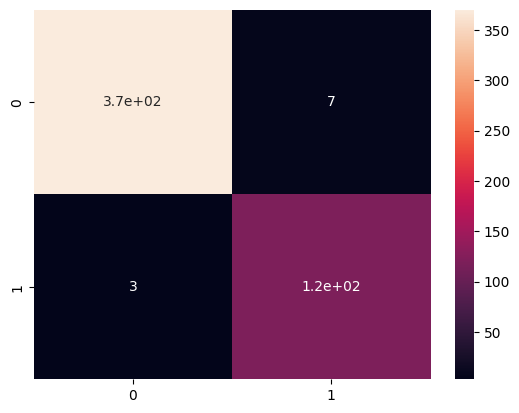

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)